In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Thu Jun  9 19:01:34 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   58C    P0    31W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 27.3 gigabytes of available RAM

You are using a high-RAM runtime!


In [ ]:
import tensorflow as tf		# TensorFlow object reference
from tensorflow import keras	# Keras is a high level API used in TensorFlow that allows us to more easily create neural networks by writing "less code". Keras does most of the heavy lifting for us when creating models. Since we won't be defining our own Tensors and diving deep into the neural network code, Keras allows us to create a simple network quickly.
import numpy as np		# A numerical function library for Python
import matplotlib.pyplot as plt		# matplotlib will allow us to graph data we're using
import time
import pandas as pd
import numpy as np
import os
from glob import glob
import random
import seaborn as sns
pd.set_option('display.max_colwidth', None)

In [ ]:
class_names = ['Normal','Left', 'Right','Atrial','Ventricular','Supra Ventricular',
               'Paced Beat','FUPBN','FUVN','IQRS','Vfl','Nodal','AAPB','AEB','NJPB',
               'Unclassifiable_beat','VEB']

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow import keras

In [ ]:
train_dir = "/content/drive/MyDrive/output_1/train"
test_dir = "/content/drive/MyDrive/output_1/test"
val_dir = "/content/drive/MyDrive/output_1/val"

In [ ]:
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import layers


In [ ]:
keras.backend.clear_session()

In [ ]:
import tensorflow as tf
IMG_SIZE = (224, 224)
train_data = tf.keras.preprocessing.image_dataset_from_directory(train_dir, batch_size=32,
                                                                            label_mode="categorical",
                                                                            image_size=IMG_SIZE)
# Note: the test data is the same as the previous experiment, we could
# skip creating this, but we'll leave this here to practice.
test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                label_mode="categorical",
                                                                image_size=IMG_SIZE,
                                                                shuffle=False)

val_data = tf.keras.preprocessing.image_dataset_from_directory(val_dir,
                                                                label_mode="categorical",
                                                                image_size=IMG_SIZE
                                                                )


Found 17662 files belonging to 17 classes.
Found 2218 files belonging to 17 classes.
Found 2204 files belonging to 17 classes.


In [ ]:
# Setup the input shape to our model
input_shape = (224, 224, 3)

# Create a frozen base model
base_model = tf.keras.applications.EfficientNetB7(include_top=False)
base_model.trainable = False


In [ ]:
# Create input and output layers
inputs = layers.Input(shape=input_shape, name="input_layer") # create input layer
#x = data_augmentation(inputs) # augment our training images
x = base_model(inputs, training=False) # pass augmented images to base model but keep it in inference mode, so batchnorm layers don't get updated: https://keras.io/guides/transfer_learning/#build-a-model
x = layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)
outputs = layers.Dense(17, activation="softmax", name="output_layer")(x)
model_2 = tf.keras.Model(inputs, outputs)


In [ ]:
model_2.compile(loss="categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(lr=0.001), # use Adam optimizer with base learning rate
              metrics=["accuracy"])


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:
!pip install model_profiler

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from model_profiler import model_profiler

Batch_size = 32
profile = model_profiler(base_model, Batch_size)

print(profile)


| Model Profile                    | Value    | Unit    |
|----------------------------------|----------|---------|
| Selected GPUs                    | ['0']    | GPU IDs |
| No. of FLOPs                     | 122.0773 | BFLOPs  |
| GPU Memory Requirement           | 0.1505   | GB      |
| Model Parameters                 | 64.0977  | Million |
| Memory Required by Model Weights | 244.5133 | MB      |


/usr/local/lib/python3.7/dist-packages/model_profiler/profiler.py:72: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  np.asarray(values).reshape(-1,1),


In [ ]:
initial_epochs = 20
Fine_tuning_entire_dataset = model_2.fit(train_data,
                                          epochs=initial_epochs,
                                          validation_data=val_data,
                                          validation_steps=int(0.25 * len(val_data)), # do less steps per validation (quicker)
                                          )

Epoch 1/20
552/552 [==============================] - 165s 251ms/step - loss: 1.4176 - accuracy: 0.6167 - val_loss: 1.0177 - val_accuracy: 0.7555
Epoch 2/20
552/552 [==============================] - 133s 241ms/step - loss: 0.8739 - accuracy: 0.7664 - val_loss: 0.7682 - val_accuracy: 0.7941
Epoch 3/20
552/552 [==============================] - 134s 241ms/step - loss: 0.7081 - accuracy: 0.8061 - val_loss: 0.7059 - val_accuracy: 0.7868
Epoch 4/20
552/552 [==============================] - 133s 241ms/step - loss: 0.6169 - accuracy: 0.8284 - val_loss: 0.6108 - val_accuracy: 0.8364
Epoch 5/20
552/552 [==============================] - 134s 241ms/step - loss: 0.5571 - accuracy: 0.8418 - val_loss: 0.5575 - val_accuracy: 0.8346
Epoch 6/20
552/552 [==============================] - 135s 243ms/step - loss: 0.5153 - accuracy: 0.8497 - val_loss: 0.5470 - val_accuracy: 0.8290
Epoch 7/20
552/552 [==============================] - 134s 242ms/step - loss: 0.4832 - accuracy: 0.8607 - val_loss: 0.4821 -

In [ ]:
test_results = model_2.evaluate(test_data)
test_results

70/70 [==============================] - 17s 236ms/step - loss: 0.3066 - accuracy: 0.8950


[0.3065887987613678, 0.8949503898620605]

In [ ]:
y_labels = []
for images, labels in test_data.unbatch(): # unbatch the test data and get images and labels
  y_labels.append(labels.numpy().argmax()) # append the index which has the largest value (labels are one-hot)
y_labels[:10] # check what they look like (unshuffled)

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

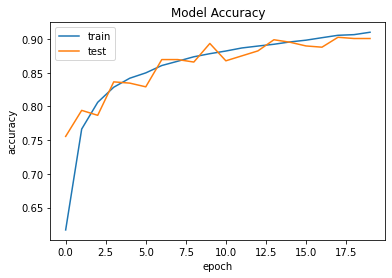

In [ ]:
import matplotlib.pyplot as plt
#plotting the Accuracy of test and training sets
plt.plot(Fine_tuning_entire_dataset.history['accuracy'])
plt.plot(Fine_tuning_entire_dataset.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

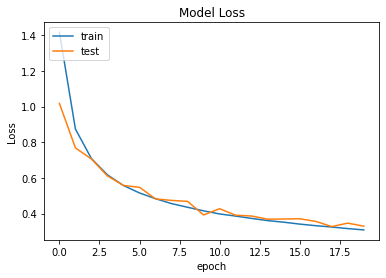

In [ ]:
import matplotlib.pyplot as plt
#plotting the Accuracy of test and training sets
plt.plot(Fine_tuning_entire_dataset.history['loss'])
plt.plot(Fine_tuning_entire_dataset.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
#@title Default title text
y_pred = model_2.predict(test_data)
y_pred = np.argmax(y_pred,axis=1)

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
print(classification_report(y_labels,y_pred))

              precision    recall  f1-score   support

           0       0.88      0.47      0.61        15
           1       0.00      0.00      0.00         3
           2       0.81      0.81      0.81       200
           3       0.90      0.80      0.85       130
           4       0.84      0.57      0.68       131
           5       0.88      0.98      0.93       209
           6       0.96      0.98      0.97       200
           7       0.53      0.89      0.67         9
           8       1.00      0.42      0.59        24
           9       0.98      0.99      0.99       200
          10       0.94      0.95      0.94       185
          11       0.96      0.97      0.97       200
          12       0.80      0.83      0.81       201
          13       0.98      1.00      0.99       251
          14       1.00      0.92      0.96        12
          15       1.00      0.77      0.87        48
          16       0.77      0.92      0.84       200

    accuracy              

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
classes=[i for i in range(17)]
con_mat_df = pd.DataFrame(confusion_matrix(y_labels,y_pred),
                     index = classes,
                     columns = classes)

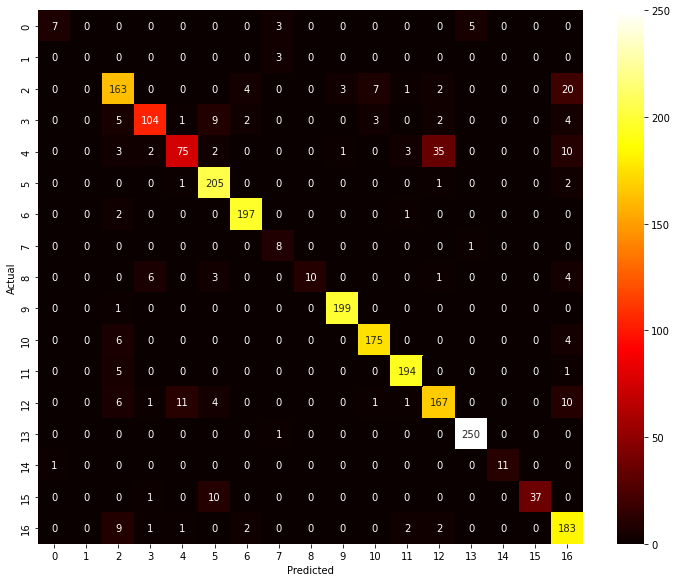

In [ ]:
import seaborn as sns
figure = plt.figure(figsize=(10, 8))
sns.heatmap(con_mat_df, annot=True,cmap=plt.cm.hot,fmt='d')
plt.tight_layout()
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

In [ ]:
model_2.layers

In [ ]:
for layer in model_2.layers:
  print(layer.trainable)

True
False
True
True


In [ ]:
model_2.summary()

In [ ]:
# How many layers are trainable in our base model?
print(len(model_2.layers[1].trainable_variables)) # layer at index 2 is the EfficientNetB0 layer (the base model)

0


In [ ]:
print(len(base_model.trainable_variables))

In [ ]:
# Check which layers are tuneable (trainable)
for layer_number, layer in enumerate(base_model.layers):
  print(layer_number, layer.name, layer.trainable)

0 input_1 False
1 rescaling False
2 normalization False
3 stem_conv_pad False
4 stem_conv False
5 stem_bn False
6 stem_activation False
7 block1a_dwconv False
8 block1a_bn False
9 block1a_activation False
10 block1a_se_squeeze False
11 block1a_se_reshape False
12 block1a_se_reduce False
13 block1a_se_expand False
14 block1a_se_excite False
15 block1a_project_conv False
16 block1a_project_bn False
17 block1b_dwconv False
18 block1b_bn False
19 block1b_activation False
20 block1b_se_squeeze False
21 block1b_se_reshape False
22 block1b_se_reduce False
23 block1b_se_expand False
24 block1b_se_excite False
25 block1b_project_conv False
26 block1b_project_bn False
27 block1b_drop False
28 block1b_add False
29 block1c_dwconv False
30 block1c_bn False
31 block1c_activation False
32 block1c_se_squeeze False
33 block1c_se_reshape False
34 block1c_se_reduce False
35 block1c_se_expand False
36 block1c_se_excite False
37 block1c_project_conv False
38 block1c_project_bn False
39 block1c_drop False
4

In [ ]:
base_model.trainable = True

# Freeze all layers except for the
for layer in base_model.layers[:-406]:
  layer.trainable = False

# Recompile the model (always recompile after any adjustments to a model)
model_2.compile(loss="categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(lr=0.0001), # lr is 10x lower than before for fine-tuning
              metrics=["accuracy"])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:
for layer_number, layer in enumerate(base_model.layers):
  print(layer_number, layer.name, layer.trainable)

0 input_1 False
1 rescaling False
2 normalization False
3 stem_conv_pad False
4 stem_conv False
5 stem_bn False
6 stem_activation False
7 block1a_dwconv False
8 block1a_bn False
9 block1a_activation False
10 block1a_se_squeeze False
11 block1a_se_reshape False
12 block1a_se_reduce False
13 block1a_se_expand False
14 block1a_se_excite False
15 block1a_project_conv False
16 block1a_project_bn False
17 block1b_dwconv False
18 block1b_bn False
19 block1b_activation False
20 block1b_se_squeeze False
21 block1b_se_reshape False
22 block1b_se_reduce False
23 block1b_se_expand False
24 block1b_se_excite False
25 block1b_project_conv False
26 block1b_project_bn False
27 block1b_drop False
28 block1b_add False
29 block1c_dwconv False
30 block1c_bn False
31 block1c_activation False
32 block1c_se_squeeze False
33 block1c_se_reshape False
34 block1c_se_reduce False
35 block1c_se_expand False
36 block1c_se_excite False
37 block1c_project_conv False
38 block1c_project_bn False
39 block1c_drop False
4

In [ ]:
print(len(model_2.trainable_variables))

358


In [ ]:
# Fine tune for another 5 epochs
fine_tune_epochs = initial_epochs + 10

# Refit the model (same as model_2 except with more trainable layers)
history_fine_tuning = model_2.fit(train_data,
                                               epochs=fine_tune_epochs,
                                               validation_data=val_data,
                                               initial_epoch=Fine_tuning_entire_dataset.epoch[-1], # start from previous last epoch
                                               validation_steps=int(0.25 * len(val_data))
                                               ) #

Epoch 20/30
552/552 [==============================] - 313s 516ms/step - loss: 0.3545 - accuracy: 0.9069 - val_loss: 0.1224 - val_accuracy: 0.9706
Epoch 21/30
552/552 [==============================] - 281s 509ms/step - loss: 0.0741 - accuracy: 0.9777 - val_loss: 0.1471 - val_accuracy: 0.9669
Epoch 22/30
552/552 [==============================] - 281s 509ms/step - loss: 0.0461 - accuracy: 0.9842 - val_loss: 0.0632 - val_accuracy: 0.9761
Epoch 23/30
552/552 [==============================] - 278s 503ms/step - loss: 0.0269 - accuracy: 0.9910 - val_loss: 0.0573 - val_accuracy: 0.9853
Epoch 24/30
552/552 [==============================] - 278s 504ms/step - loss: 0.0275 - accuracy: 0.9911 - val_loss: 0.0556 - val_accuracy: 0.9779
Epoch 25/30
552/552 [==============================] - 278s 502ms/step - loss: 0.0207 - accuracy: 0.9935 - val_loss: 0.1285 - val_accuracy: 0.9761
Epoch 26/30
552/552 [==============================] - 277s 502ms/step - loss: 0.0187 - accuracy: 0.9940 - val_loss: 0

In [ ]:
results_fine_tune_full_data = model_2.evaluate(test_data)
results_fine_tune_full_data

70/70 [==============================] - 16s 231ms/step - loss: 0.0668 - accuracy: 0.9869


[0.06684764474630356, 0.9869251847267151]

In [ ]:
y_pred_2 = model_2.predict(test_data)
y_pred_2 = np.argmax(y_pred_2,axis=1)

In [ ]:
y_pred_2

array([ 0,  0,  0, ..., 16, 16, 16])

In [ ]:
def compare_historys(original_history, new_history, initial_epochs=5):
    """
    Compares two TensorFlow model History objects.

    Args:
      original_history: History object from original model (before new_history)
      new_history: History object from continued model training (after original_history)
      initial_epochs: Number of epochs in original_history (new_history plot starts from here)
    """

    # Get original history measurements
    acc = original_history.history["accuracy"]
    loss = original_history.history["loss"]

    val_acc = original_history.history["val_accuracy"]
    val_loss = original_history.history["val_loss"]

    # Combine original history with new history
    total_acc = acc + new_history.history["accuracy"]
    total_loss = loss + new_history.history["loss"]

    total_val_acc = val_acc + new_history.history["val_accuracy"]
    total_val_loss = val_loss + new_history.history["val_loss"]

    # Make plots
    plt.figure(figsize=(8, 8))
    plt.subplot(2, 1, 1)
    plt.plot(total_acc, label='Training Accuracy')
    plt.plot(total_val_acc, label='Validation Accuracy')
    plt.plot([initial_epochs-1, initial_epochs-1],
              plt.ylim(), label='Start Fine Tuning') # reshift plot around epochs
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(2, 1, 2)
    plt.plot(total_loss, label='Training Loss')
    plt.plot(total_val_loss, label='Validation Loss')
    plt.plot([initial_epochs-1, initial_epochs-1],
              plt.ylim(), label='Start Fine Tuning') # reshift plot around epochs
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.xlabel('epoch')
    plt.show()

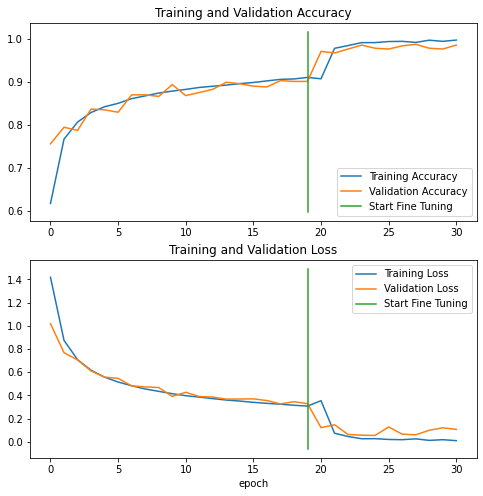

In [ ]:
compare_historys(original_history=Fine_tuning_entire_dataset,
                 new_history=history_fine_tuning,
                 initial_epochs=20)

In [ ]:
# Get accuracy score by comparing predicted classes to ground truth labels
from sklearn.metrics import accuracy_score
sklearn_accuracy = accuracy_score(y_labels, y_pred_2)
sklearn_accuracy

0.9869251577998197

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
print(classification_report(y_labels,y_pred_2))

              precision    recall  f1-score   support

           0       1.00      0.87      0.93        15
           1       1.00      0.67      0.80         3
           2       0.98      0.94      0.96       200
           3       0.96      1.00      0.98       130
           4       1.00      0.99      1.00       131
           5       1.00      0.98      0.99       209
           6       1.00      0.99      1.00       200
           7       0.90      1.00      0.95         9
           8       1.00      0.79      0.88        24
           9       1.00      1.00      1.00       200
          10       1.00      0.99      1.00       185
          11       1.00      1.00      1.00       200
          12       0.97      1.00      0.98       201
          13       0.99      1.00      1.00       251
          14       1.00      1.00      1.00        12
          15       1.00      1.00      1.00        48
          16       0.95      0.99      0.97       200

    accuracy              

In [ ]:
classes=[i for i in range(17)]
con_mat_df = pd.DataFrame(confusion_matrix(y_labels,y_pred_2),
                     index = classes,
                     columns = classes)

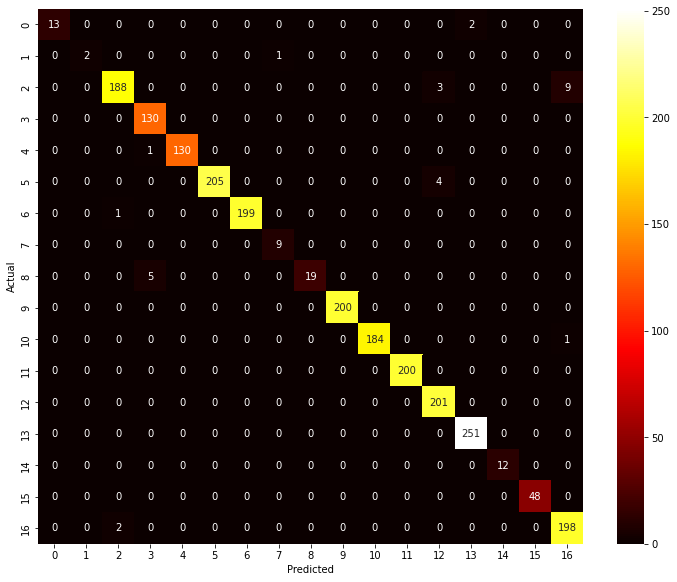

In [ ]:
import seaborn as sns
figure = plt.figure(figsize=(10, 8))
sns.heatmap(con_mat_df, annot=True,cmap=plt.cm.hot,fmt='d')
plt.tight_layout()
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()